# Residual Network for Image Classification

This is a RESNET model to classify handwritten numerical digits and mathematical symbols as part of a data science competition.

- Each row of the training data contains 576 elements representing an unrolled 24 x 24 handwritten image of one of the following digits or symbols:
-- 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, +, -, =
- Each row of the label data contains a single integer from 1 to 13 representing the 1-based position of the digit/symbol in the list above.
- Each row in the test/challenge data containg 2880 elements representing an unrolled 24 x 120 image of a handwritten equation. An equation is made up of 5 characters from the list above (3 digits and 2 symbols).

This model is based on code from Andrew Ng's [Convolutional Neural Networks](https://www.coursera.org/learn/convolutional-neural-networks) course as part of his [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)  on Coursera.

In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, Dropout, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot

import matplotlib.pyplot as plt
import pandas as pd
import openpyxl

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [2]:
def identity_block(X, f, filters, stage, block):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [3]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s, s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

Below is a modified ResNet model with 11 layers, which I call ResNet11
- Dropout included before the first Conv2D layer in stage 1
- Dropout included before the last convolutional_block layer in stage 2
- Padding and filter dimensions modified to suit the image dimensions (24 x 24)

In [4]:
def ResNet11(input_shape, classes):
    """
    Implementation of the popular ResNet11 the following architecture:
    DROPOUT -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> DROPOUT -> CONVBLOCK -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Dropout(0.1)(X)
    X = Conv2D(24, (5, 5), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [24, 24, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [24, 24, 128], stage = 2, block='b')
    X = identity_block(X, 3, [24, 24, 128], stage = 2, block='c')
    X = Dropout(0.05)(X)
    X = convolutional_block(X, f = 3, filters = [32, 32, 256], stage = 3, block='a', s = 2)

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((1, 1), name = 'avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dropout(0.1)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

A number of helper functions are defined below to manipulate the data and run predictions

In [6]:
def split_data(input_data, label_data, train_ratio): # train_ratio is the fraction to be used for training
    
    '''
    Function to split data into training and test sets
    
    Input:
        input_data:  2-D array with 576 columns
        label_data:  2-D array with 1 column
        train_ratio: number between 0 and 1 specifying fraction of data to be used for training
    Output:
        train_dataset: 4-D array of 24 x 24 x 1 images 
        train_labels:  2-D array with 13 columns
        test_dataset:  4-D array of 24 x 24 x 1 images 
        test_labels:   2-D array with 13 columns
    '''
    
    assert(0 < train_ratio <= 1)
    
    train_rows = int(train_ratio * len(input_data))
    
    train_dataset = input_data[:train_rows]
    train_labels = label_data[:train_rows]
    test_dataset = input_data[train_rows:]
    test_labels = label_data[train_rows:]
    
    return train_dataset, train_labels, test_dataset, test_labels

In [7]:
def recreate_equations(symbols):
    
    '''
    Function to reassemble symbols into equations.
    Each equation is made up of 5 symbols
    
    Input:  4-D array of 24 x 24 x 1 images 
    Output: 2-D list of 5 columns
    '''
    
    equation = []
    predictions = []
    
    for s in symbols:        
        if len(equation) == 5:
            predictions.append(equation)
            equation = []
        equation.append(np.argmax(s))
        
    predictions.append(equation) # append the last equation
        
    return predictions

In [8]:
# function to write predicted output to 'output_file' using openpyxl

def predict_output(predicted_equations, output_file):
    
    '''
    Function to write predicted output to a csv file
    
    Input:
        2-D list with 5 columns
        Name of output file
    '''
    
    book = openpyxl.Workbook()
    sheet = book.get_active_sheet()

    # write header row
    row_number = 1 # 1st row in excel sheet
    sheet['A1'].value = 'index'
    sheet['B1'].value = 'label'

    for equation in predicted_equations:

        row_number += 1 # write to next row  

        a = equation[0]
        b = equation[2]
        c = equation[4]

        if equation[1] == 12: # '=' sign
            if equation[3] == 10: # '+' sign
                sheet['A' + str(row_number)].value = row_number - 2
                sheet['B' + str(row_number)].value = int(a == b + c)
            else: # equation[3] is 11 (the '-' sign)
                sheet['A' + str(row_number)].value = row_number - 2
                sheet['B' + str(row_number)].value = int(a == b - c)
        else: # equation[3] is the equal sign
            if equation[1] == 10: # '+' sign
                sheet['A' + str(row_number)].value = row_number - 2
                sheet['B' + str(row_number)].value = int(a + b == c)
            else: # equation[1] is 11 (the '-' sign)
                sheet['A' + str(row_number)].value = row_number - 2
                sheet['B' + str(row_number)].value = int(a - b == c)

    book.save(output_file)

#### We are now ready to read in the data and run the ResNet model on it

In [9]:
image_size = 24
num_labels = 13

In [10]:
input_data = np.array(pd.read_csv('train_dataset.csv').drop('index', axis = 1)).astype(np.float32)
labels = np.array(pd.read_csv('train_labels.csv').drop('index', axis = 1))
    
print('Input data dimensions:', input_data.shape, 'Label data dimensions:', labels.shape)

Input data dimensions: (80000, 576) Label data dimensions: (80000, 1)


Resize the images into 3-D arrays

In [11]:
input_data = input_data.reshape(-1, image_size, image_size, 1)
label_data = (np.arange(num_labels) == labels[:]).astype(np.float32)

print('Input data dimensions:', input_data.shape, 'Label data dimensions:', label_data.shape)

Input data dimensions: (80000, 24, 24, 1) Label data dimensions: (80000, 13)


Split the input and label data into training and test sets

In [12]:
train_dataset, train_labels, test_dataset, test_labels = split_data(input_data, label_data, 0.9)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (72000, 24, 24, 1) (72000, 13)
Test set (8000, 24, 24, 1) (8000, 13)


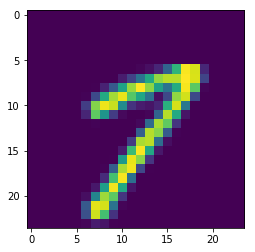

In [13]:
# Take a peek at the data
plt.imshow(train_dataset[1].reshape(24, 24))
plt.show()

Create and compile the Keras model

In [293]:
model = ResNet50(input_shape = (image_size, image_size, 1), classes = num_labels)

In [294]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

We can now train the model

In [296]:
model.fit(train_dataset, train_labels, epochs = 50, batch_size = 256)

Epoch 1/50
72000/72000 [==============================] - 478s 7ms/step - loss: 0.2929 - acc: 0.9073

Let's see how this model performs on the test set:

In [297]:
preds = model.evaluate(test_dataset, test_labels)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

8000/8000 [==============================] - 44s 5ms/step

#### We will now use the trained model to predict the values of the images in the equations

Read in the equations

In [14]:
equations = np.array(pd.read_csv('test.csv').drop('index', axis = 1)).astype(np.float32)

We need to represent this data in a form that our model understands, i.e. 3-D images of shape 24 x 24 x 1

Each equation is a 24 x 120 image containing 5 characters each of shape 24 x 24. However, the input from the file contains one row of 2880 entries (i.e. 24 x 120) for each equation.
- We will first reshape each row into a 24 x 120 image
- Then we will extract the 5 characters/symbols from the image equation by reshaping that to (-1, 24, 24). The unknown dimension (-1) in this case will be 5
- Finally, we will save the extracted characters/symbols in a list of symbols s. We will reshape them to 3-D images before saving them in s

In [15]:
s = []

In [16]:
for equation in equations:
    x = np.transpose(equation.reshape(-1, 120)).reshape(-1, 24, 24)
    for y in x:
        s.append(np.transpose(y).reshape(-1, 24, 24, 1))

In [17]:
symbols = np.asarray(s)

In [18]:
symbols.shape

(100000, 1, 24, 24, 1)

In [19]:
symbols = symbols.reshape(100000, 24, 24, 1)

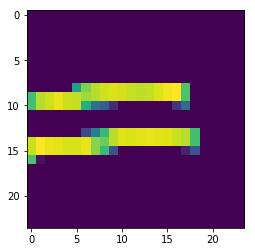

In [20]:
#Take a peek
plt.imshow(symbols[3].reshape(24, 24))
plt.show()

Carry out the prediction

In [298]:
predicted_symbols = model.predict(symbols)

In [299]:
# Print out the prediction for the 7th equation
# Thankfully, this matches the actual equation in the 7th row of the input (shown in the next cell)
print('{} {} {} {} {}'.format(np.argmax(predicted_symbols[30]), np.argmax(predicted_symbols[31]), np.argmax(predicted_symbols[32]), np.argmax(predicted_symbols[33]), np.argmax(predicted_symbols[34])))

6 11 2 12 5


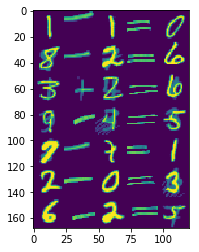

In [282]:
plt.imshow(equations[:7].reshape(-1, 120))
plt.show()

Reassemble the symbols into complete equations (5 symbols per equation)

In [300]:
eqs = recreate_equations(predicted_symbols)

Save the predictions to 'output.csv'

In [301]:
predict_output(eqs, 'output.csv')

And that's that!

The accuracy of our predictions will be tested by the competition's grader.

In the meantime, it is possible to tweak a number of parameters to improve our accuracy:
- learning rate
- number and components of layers
- number of neurons in different layers
- dropout probability
- number of iterations/epochs
and so on.

The lines below will display and save a graphic of our model

In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file = 'model.png')
SVG(model_to_dot(model).create(prog='dot', format = 'svg'))